In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# General Imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from sklearn.metrics import confusion_matrix

# Neural Network imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam

# Image augmentation importrs
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomContrast
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomTranslation

# Training Model callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint



SEED= 111

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

2024-08-06 14:35:15.763547: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 14:35:15.763679: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 14:35:15.902390: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def get_data_labels(directory, shuffle=True, random_state=0):
    from sklearn.utils import shuffle
    data_path = []
    data_index = []
    label_dict = {label: index for index, label in enumerate(sorted(os.listdir(directory)))}

    for label, index in label_dict.items():
        label_dir = os.path.join(directory, label)
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_index.append(index)

    if shuffle:
        data_path, data_index = shuffle(data_path, data_index, random_state=random_state)

    return data_path, data_index

def parse_function(filename, label, image_size, n_channels):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, n_channels)
    image = tf.image.resize(image, image_size)
    return image, label

def get_dataset(paths, labels, image_size, n_channels=3, num_classes=4, batch_size=128):
    path_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    image_label_ds = path_ds.map(lambda path, label: parse_function(path, label, image_size, n_channels),
                                 num_parallel_calls=tf.data.AUTOTUNE)
    return image_label_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [3]:
# Getting data labels
USER_PATH = "/kaggle/input/brain-tumor-mri-dataset"
train_paths, train_index = get_data_labels('/kaggle/input/brain-tumor-mri-dataset/Training', random_state=SEED)
test_paths, test_index = get_data_labels('/kaggle/input/brain-tumor-mri-dataset/Testing', random_state=SEED)

# Printing traing and testing sample sizes
print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

# Prepare datasets with 4 classes and grayscale
batch_size = 128
image_dim = (168, 168)
train_ds = get_dataset(train_paths, train_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)
test_ds = get_dataset(test_paths, test_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)

# Output to show datasets
print(f"\nTraining dataset: {train_ds}")
print(f"\nTesting dataset: {test_ds}")

# Class mappings
class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}
inv_class_mappings = {v: k for k, v in class_mappings.items()}
class_names = list(class_mappings.keys())

Training
Number of Paths: 5712
Number of Labels: 5712

Testing
Number of Paths: 1311
Number of Labels: 1311

Training dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 168, 168, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Testing dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 168, 168, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


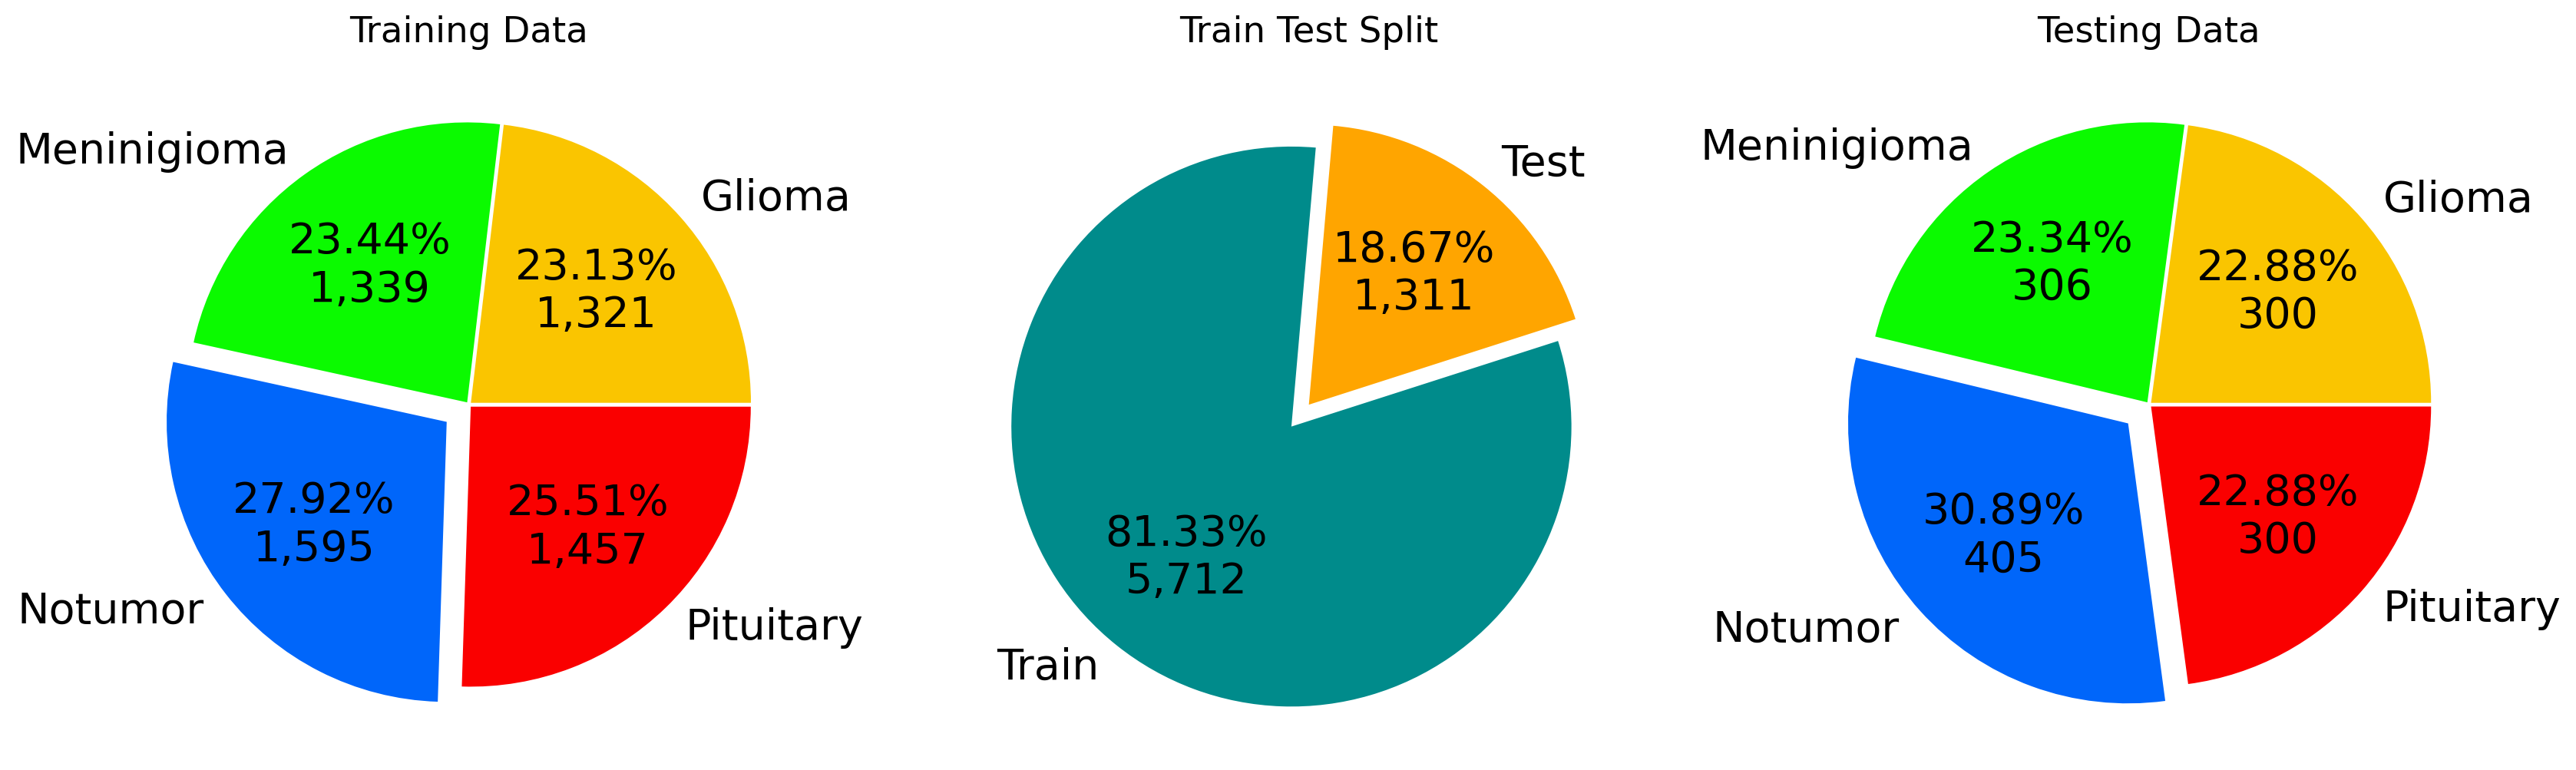

In [4]:
_, ax = plt.subplots(ncols=3, figsize=(20, 14))

# Plotting training data types
class_counts = [len([x for x in train_index if x == label]) for label in set(train_index)]
ax[0].set_title('Training Data')
ax[0].pie(
    class_counts,
    labels=[label for label in class_names],
    colors=['#FAC500','#0BFA00', '#0066FA','#FA0000'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=(0.01, 0.01, 0.1, 0.01),
    textprops={'fontsize': 20}
)

# Plotting distribution of train test split
ax[1].set_title('Train Test Split')
ax[1].pie(
    [len(train_index), len(test_index)],
    labels=['Train','Test'],
    colors=['darkcyan', 'orange'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum([len(train_index), len(test_index)]) / 100),
    explode=(0.1, 0),
    startangle=85,
    textprops={'fontsize': 20}
)

# Plotting testing data types
class_counts = [len([x for x in test_index if x == label]) for label in set(test_index)]
ax[2].set_title('Testing Data')
ax[2].pie(
    class_counts,
    labels=[label for label in class_names],
    colors=['#FAC500', '#0BFA00', '#0066FA', '#FA0000'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=(0.01, 0.01, 0.1, 0.01),
    textprops={'fontsize': 20}
)

plt.show()

In [6]:
# Function to display a list of images based on the given index
def show_images(paths, label_paths, class_mappings, index_list=range(10), im_size=250, figsize=(12, 8)):

    num_images = len(index_list)
    num_rows = (num_images + 3) // 4
    index_to_class = {v: k for k, v in class_mappings.items()}
    _, ax = plt.subplots(nrows=num_rows, ncols=4, figsize=figsize)
    ax = ax.flatten()

    for i, index in enumerate(index_list):
        if i >= num_images:
            break
        image = load_img(paths[index], target_size=(im_size, im_size), color_mode='grayscale')
        ax[i].imshow(image, cmap='Greys_r')
        class_name = index_to_class[label_paths[index]]
        ax[i].set_title(f'{index}: {class_name}')
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()

In [7]:
# Four different classes images from different angles
# Dta augmentation sequential model
data_augmentation = Sequential([
    # RandomFlip("horizontal_and_vertical"),
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

# Training augmentation and nornalization
def preprocess_train(image, label):
    # Apply data augmentation and Normalize
    image = data_augmentation(image) / 255.0
    return image, label

# For test dataset only appying normalization
def preprocess_test(image, label):
    return image / 255.0, label

# Apply transformation to training and testing datasets
train_ds_preprocessed = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

In [8]:
# Function to display augmented images
def plot_augmented_images(dataset, shape, class_mappings, figsize=(15, 6)):
    plt.figure(figsize=figsize)
    index_to_class = {v: k for k, v in class_mappings.items()}
    for images, label in dataset.take(1):
        i = 0
        for i in range(shape[0]*shape[1]):
            ax = plt.subplot(shape[0], shape[1], i + 1)
            plt.imshow(images[i].numpy().squeeze(), cmap='gray')
            plt.title(index_to_class[label.numpy()[i]])
            plt.axis("off")
            i += 1

    plt.tight_layout()
    plt.show()

In [9]:
import tensorflow as tf
# Classes and Image shape: height, width, grayscale
num_classes = len(class_mappings.keys())
image_shape = (image_dim[0], image_dim[1], 1)

# Training epochs and batch size
epochs = 20
print(f'Number of Classes: {num_classes}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')



def encode_labels(image, label):
    label = tf.cast(label, tf.int32)
    return image, tf.one_hot(label, depth=num_classes)

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)

Number of Classes: 4
Image shape: (168, 168, 1)
Epochs: 20
Batch size: 128


In [10]:
# Define input shape
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

# Define input shape
height, width = 168, 168
input_shape = (height, width, 1)
num_classes = 4
height, width = 168, 168
input_shape = (height, width, 1)
num_classes = 4

# Define simple CNN architecture
def simple_cnn(input_shape):
    input_layer = Input(shape=input_shape)
    conv1 = Conv2D(32, (3, 3), activation='relu')(input_layer)
    pool1 = MaxPooling2D((2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)
    flatten = Flatten()(pool2)
    dense1 = Dense(128, activation='relu')(flatten)
    output_layer = Dense(num_classes, activation='softmax')(dense1)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and compile the model
model = simple_cnn(input_shape)

# Print model summary
model.summary()

# Compile model with Adam optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.9925)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 168, 168, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 166, 166, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 83, 83, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 81, 81, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 102400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    13,107,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,126,660 (50.07 MB)

 Trainable params: 13,126,660 (50.07 MB)

 Non-trainable params: 0 (0.00 B)

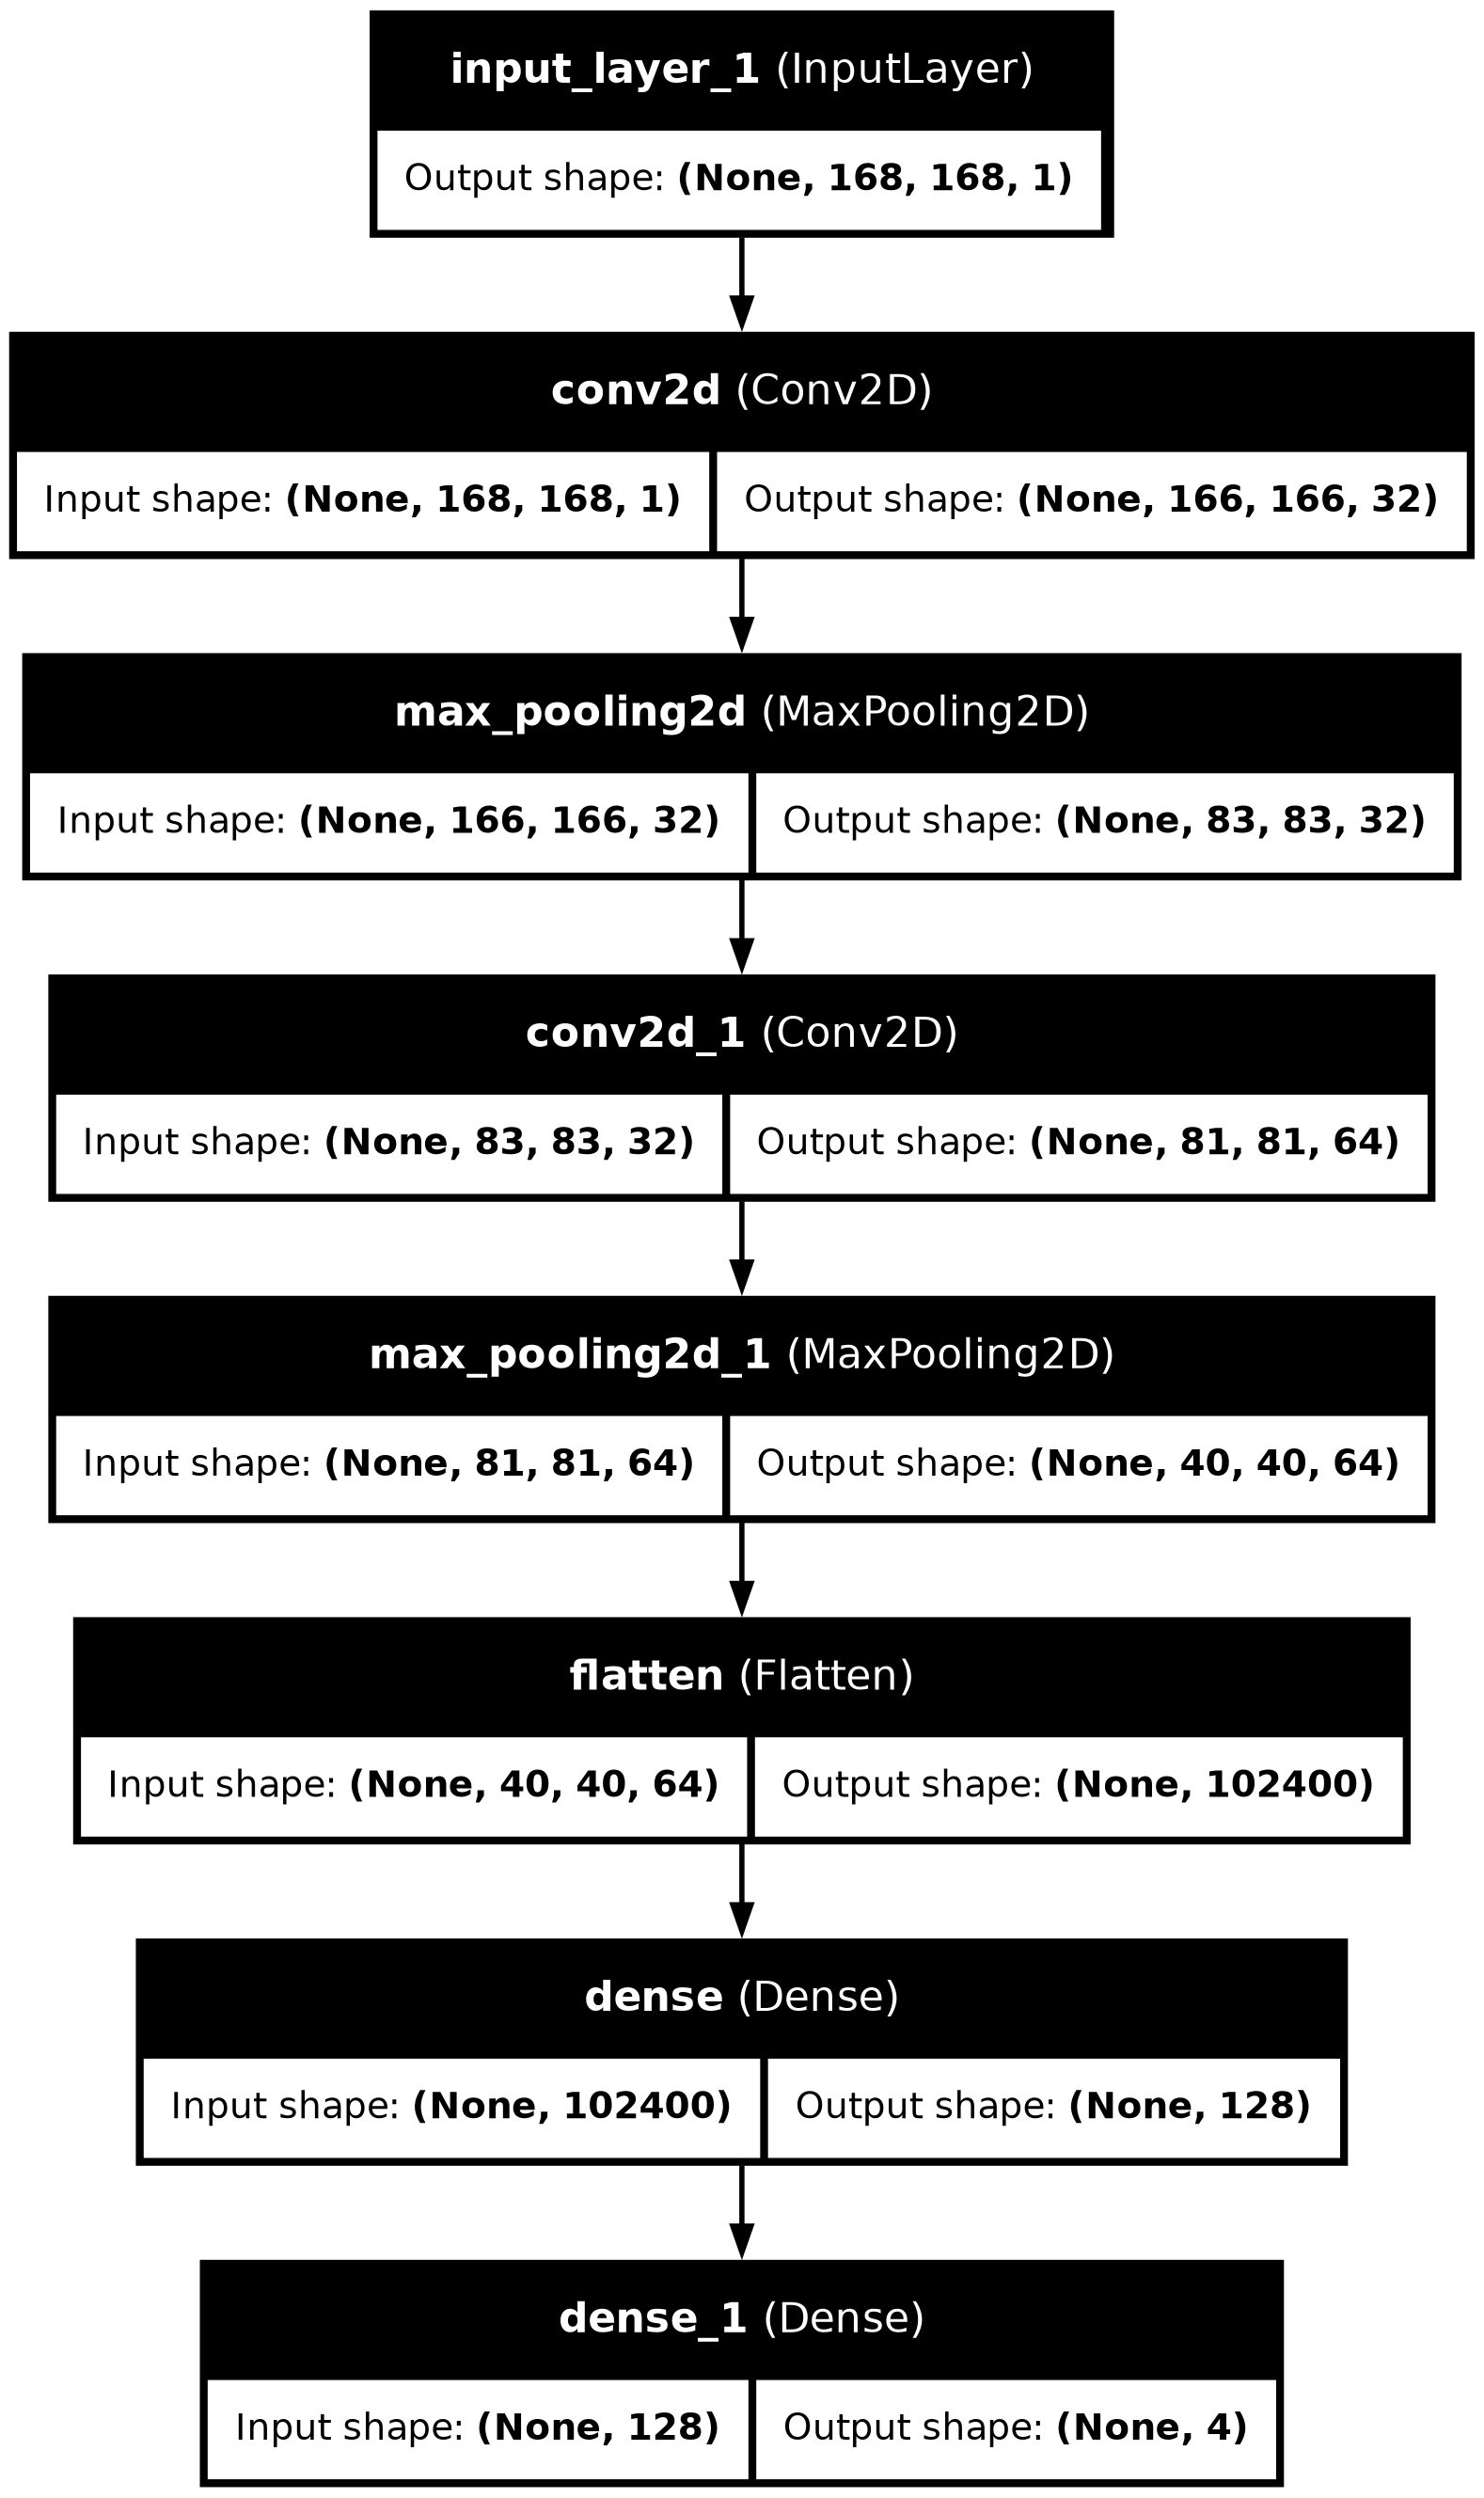

In [11]:
from keras.utils import plot_model
# Save the visualization to a file
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [12]:
# Custom callback for reducing learning rate at accuracy values
class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds  # List of accuracy thresholds
        self.factor = factor  # Factor to reduce the learning rate
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds)  # Track each threshold

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True  # Mark this threshold as reached
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

# Try a custom callback
thresholds = [0.96, 0.99, 0.9935]
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)

In [13]:
# Callbacks for improved covergence of gradient and best test accuracy
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint('model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

# Training the model
history = model.fit(
    train_ds_preprocessed,
    epochs=epochs,
    validation_data=test_ds_preprocessed,
    callbacks=[model_rlr, model_mc],
    verbose=True
)

Epoch 1/20


2024-08-06 14:45:34.121869: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.12745, expected 1.57878
2024-08-06 14:45:34.121920: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 1.63617, expected 1.0875
2024-08-06 14:45:34.121929: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 1.71745, expected 1.16878
2024-08-06 14:45:34.121937: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.04246, expected 1.49379
2024-08-06 14:45:34.121945: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 1.72679, expected 1.17812
2024-08-06 14:45:34.121953: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 1.85579, expected 1.30712
2024-08-06 14:45:34.121961: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 1.95174, expected 1.40307
2024-08-06 14:45:34.121969: E external/local_xla/xla/ser

 2/45 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.1758 - loss: 1.8557 

I0000 00:00:1722955542.202780     121 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.4369 - loss: 1.3761

2024-08-06 14:45:53.498320: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.40893, expected 2.77779
2024-08-06 14:45:53.498387: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.49581, expected 2.86467
2024-08-06 14:45:53.498397: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.87927, expected 2.24813
2024-08-06 14:45:53.498405: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 3.20213, expected 2.57099
2024-08-06 14:45:53.498413: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 3.58836, expected 2.95722
2024-08-06 14:45:53.498420: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 3.18543, expected 2.55429
2024-08-06 14:45:53.498428: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 3.00669, expected 2.37555
2024-08-06 14:45:53.498436: E external/local_xla/xla/se

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.4405 - loss: 1.3675

2024-08-06 14:46:00.770242: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.68427, expected 2.2369
2024-08-06 14:46:00.770304: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.05546, expected 2.60809
2024-08-06 14:46:00.770314: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 3.09327, expected 2.6459
2024-08-06 14:46:00.770322: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.53685, expected 2.08948
2024-08-06 14:46:00.770330: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 3.06113, expected 2.61376
2024-08-06 14:46:00.770337: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 3.42221, expected 2.97484
2024-08-06 14:46:00.770345: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.37979, expected 1.93242
2024-08-06 14:46:00.770353: E external/local_xla/xla/serv

45/45 ━━━━━━━━━━━━━━━━━━━━ 33s 463ms/step - accuracy: 0.4439 - loss: 1.3592 - val_accuracy: 0.7132 - val_loss: 0.9750 - learning_rate: 0.0010
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 210ms/step - accuracy: 0.7980 - loss: 0.5098 - val_accuracy: 0.7948 - val_loss: 0.7889 - learning_rate: 0.0010
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 206ms/step - accuracy: 0.8446 - loss: 0.4028 - val_accuracy: 0.8238 - val_loss: 0.7237 - learning_rate: 0.0010
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - accuracy: 0.8702 - loss: 0.3399 - val_accuracy: 0.8459 - val_loss: 0.7158 - learning_rate: 0.0010
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 206ms/step - accuracy: 0.8870 - loss: 0.2979 - val_accuracy: 0.8741 - val_loss: 0.6463 - learning_rate: 0.0010
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - accuracy: 0.9201 - loss: 0.2278 - val_accuracy: 0.8993 - val_loss: 0.6623 - learning_rate: 0.0010
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 210ms/step - accuracy: 0.9225 - loss: 0.2075 - val_

In [14]:
model = load_model('model.keras')

# Evaluate model and test data accuracy
test_loss, test_acc = model.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_acc*100:0.2f}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9737 - loss: 0.2575
Test accuracy: 95.58%


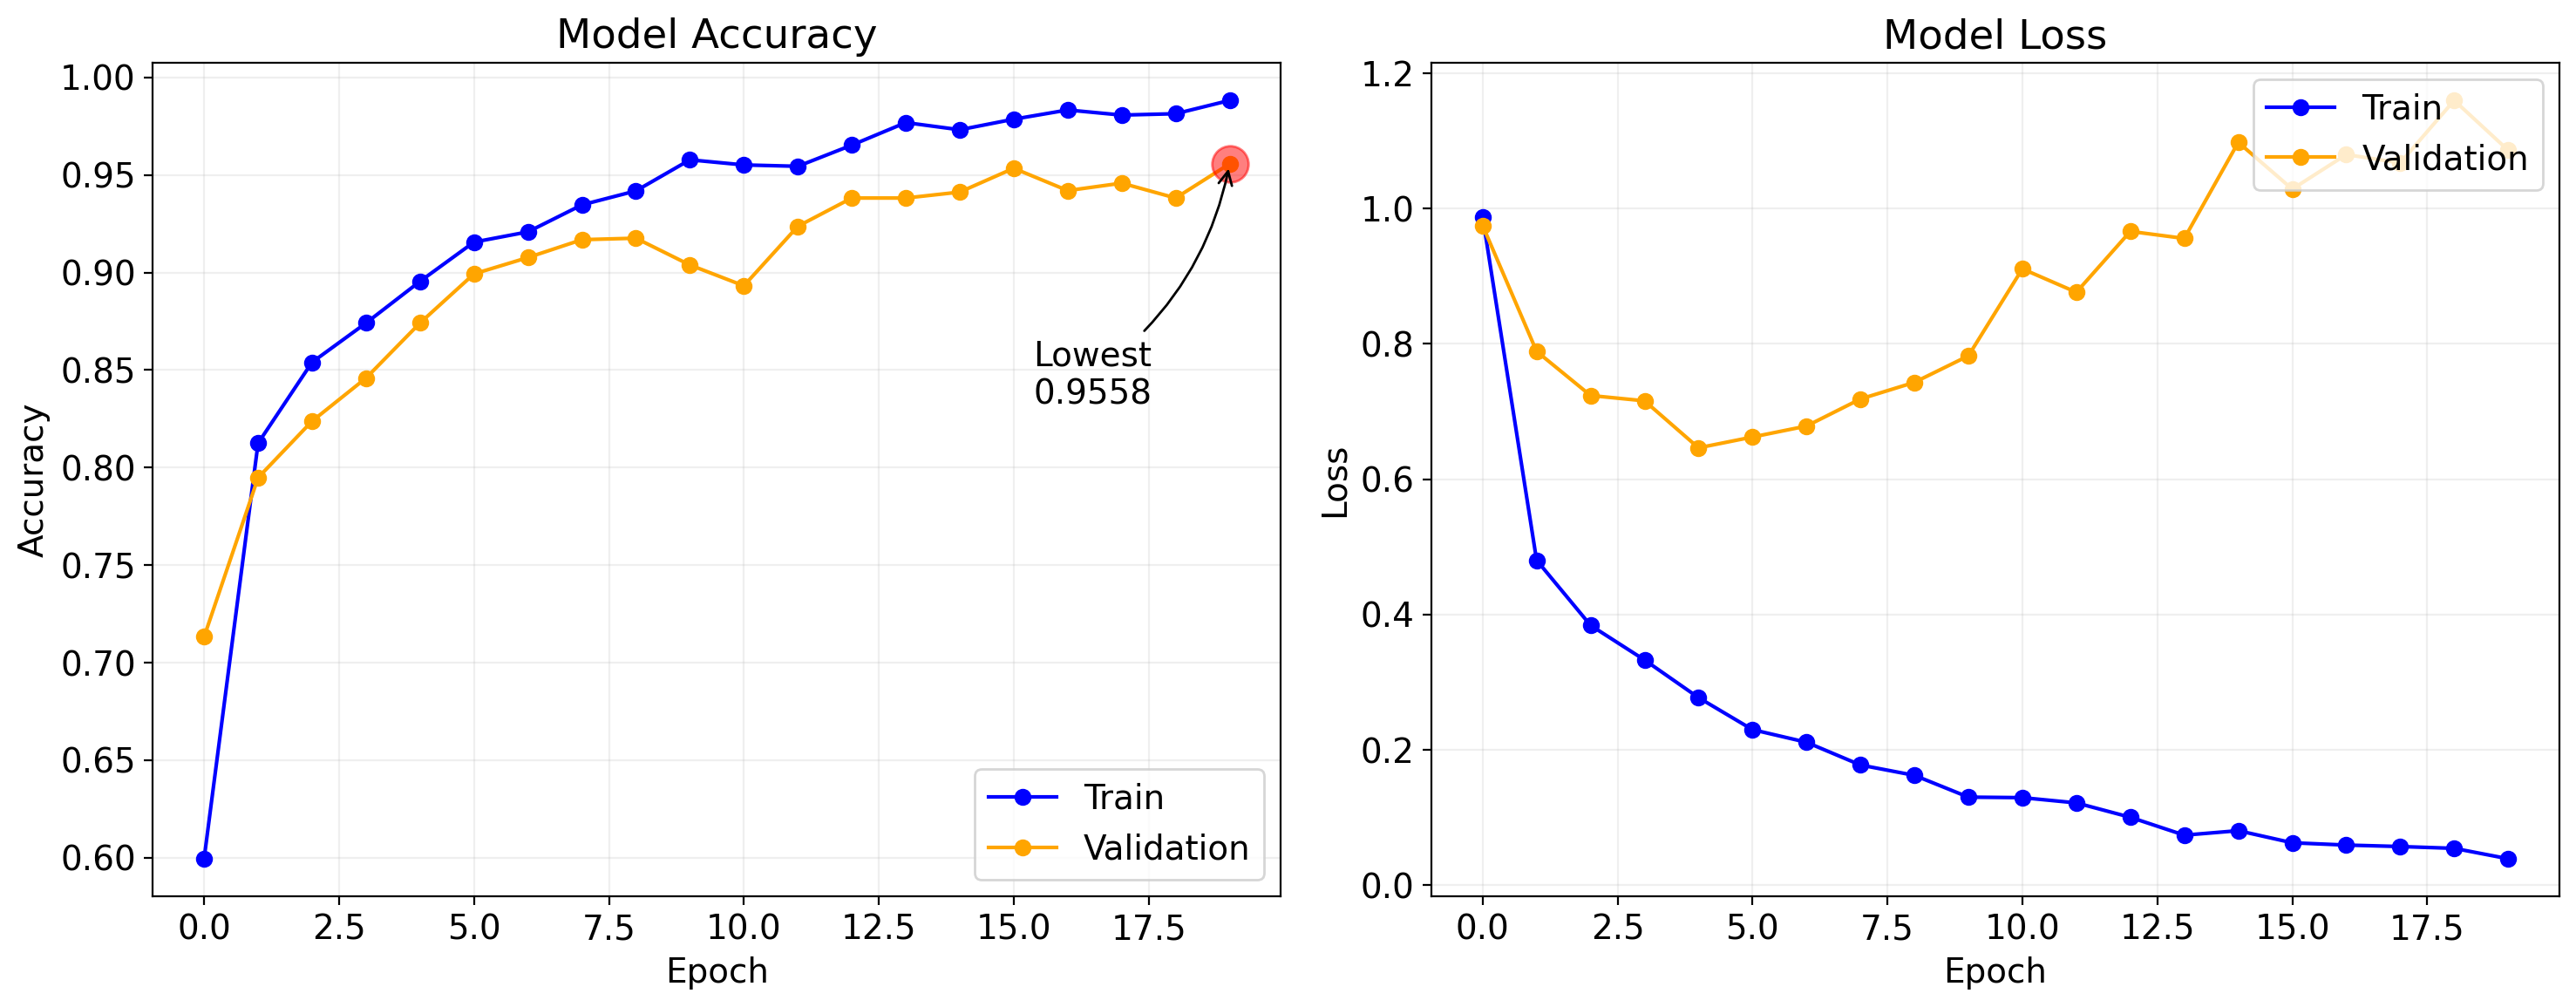

In [15]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plotting training and validation accuracy over epochs
ax[0].plot(history.history['accuracy'], marker='o', linestyle='-', color='blue')
ax[0].plot(history.history['val_accuracy'], marker='o', linestyle='-', color='orange')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'], loc='lower right')
ax[0].grid(alpha=0.2)

# Plotting training and validation loss over epochs
ax[1].plot(history.history['loss'], marker='o', linestyle='-', color='blue')
ax[1].plot(history.history['val_loss'], marker='o', linestyle='-', color='orange')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'], loc='upper right')
ax[1].grid(alpha=0.2)

# Highlight lowest validation accuracy
min_val_acc_epoch = np.argmax(history.history['val_accuracy'])
min_val_acc = np.max(history.history['val_accuracy'])
ax[0].plot(min_val_acc_epoch, min_val_acc, 'ro', markersize=15, alpha=0.5)
ax[0].annotate(f'Lowest\n{min_val_acc:.4f}', xy=(min_val_acc_epoch, min_val_acc),
               xytext=(min_val_acc_epoch - 100, min_val_acc - 100), textcoords='offset points',
               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.tight_layout()
plt.show()

In [16]:
# Using test data for true and preductions
true_labels = []
predicted_labels = []

# Iterate over dataset to collect predictions and true labels
# Unbatch to get sample-wise prediction
for images, labels in test_ds_preprocessed.unbatch():
    # Store true labels (Convert one-hot to index)
    true_label = np.argmax(labels.numpy())
    true_labels.append(true_label)

    # Get model prediction (Predict expects batch dimension)
    pred = model.predict(tf.expand_dims(images, 0), verbose=False)
    predicted_label = np.argmax(pred)
    predicted_labels.append(predicted_label)

2024-08-06 14:53:15.282565: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 27556: 3.26858, expected 2.83329
2024-08-06 14:53:15.282621: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 27557: 2.56503, expected 2.12974
2024-08-06 14:53:15.282635: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 27558: 2.61346, expected 2.17817
2024-08-06 14:53:15.282650: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 27559: 3.19876, expected 2.76347
2024-08-06 14:53:15.282665: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 27560: 2.9236, expected 2.48832
2024-08-06 14:53:15.282680: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 27561: 2.59528, expected 2.15999
2024-08-06 14:53:15.282694: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 27562: 3.11228, expected 2.677
2024-08-06 14:53:15.282709: E 

In [18]:
def plot_confusion_matrix(true_labels, predicted_labels, class_mappings, metrics=False, cmap='Blues'):
    # Compute  confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    # Mapping of indices to class names in class_mappings
    plt.xticks(ticks=np.arange(num_classes) + 0.5, labels=class_mappings.keys(), ha='center')
    plt.yticks(ticks=np.arange(num_classes) + 0.5, labels=class_mappings.keys(), va='center')
    plt.show()

    if metrics:
        # Precision, Recall, and F1-Score for each class & Overall accuracy
        precision = np.diag(cm) / np.sum(cm, axis=0)
        recall = np.diag(cm) / np.sum(cm, axis=1)
        f1_scores = 2 * precision * recall / (precision + recall)
        accuracy = np.sum(np.diag(cm)) / np.sum(cm)

        print("Class-wise metrics:")
        for i in range(len(class_mappings)):
            class_name = list(class_mappings.keys())[i]
            print(f"\033[94mClass: {class_name}\033[0m")
            print(f"Precision: {precision[i]:.4f}")
            print(f"Recall: {recall[i]:.4f}")
            print(f"F1-Score: {f1_scores[i]:.4f}\n")

        print(f"\033[92mOverall Accuracy: {accuracy:.4f}\033[0m")

In [20]:
from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_mappings.keys())
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

      Glioma       0.49      0.46      0.47       300
 Meninigioma       0.60      0.01      0.02       306
     Notumor       1.00      0.00      0.00       405
   Pituitary       0.29      1.00      0.45       300

    accuracy                           0.34      1311
   macro avg       0.60      0.37      0.24      1311
weighted avg       0.63      0.34      0.22      1311



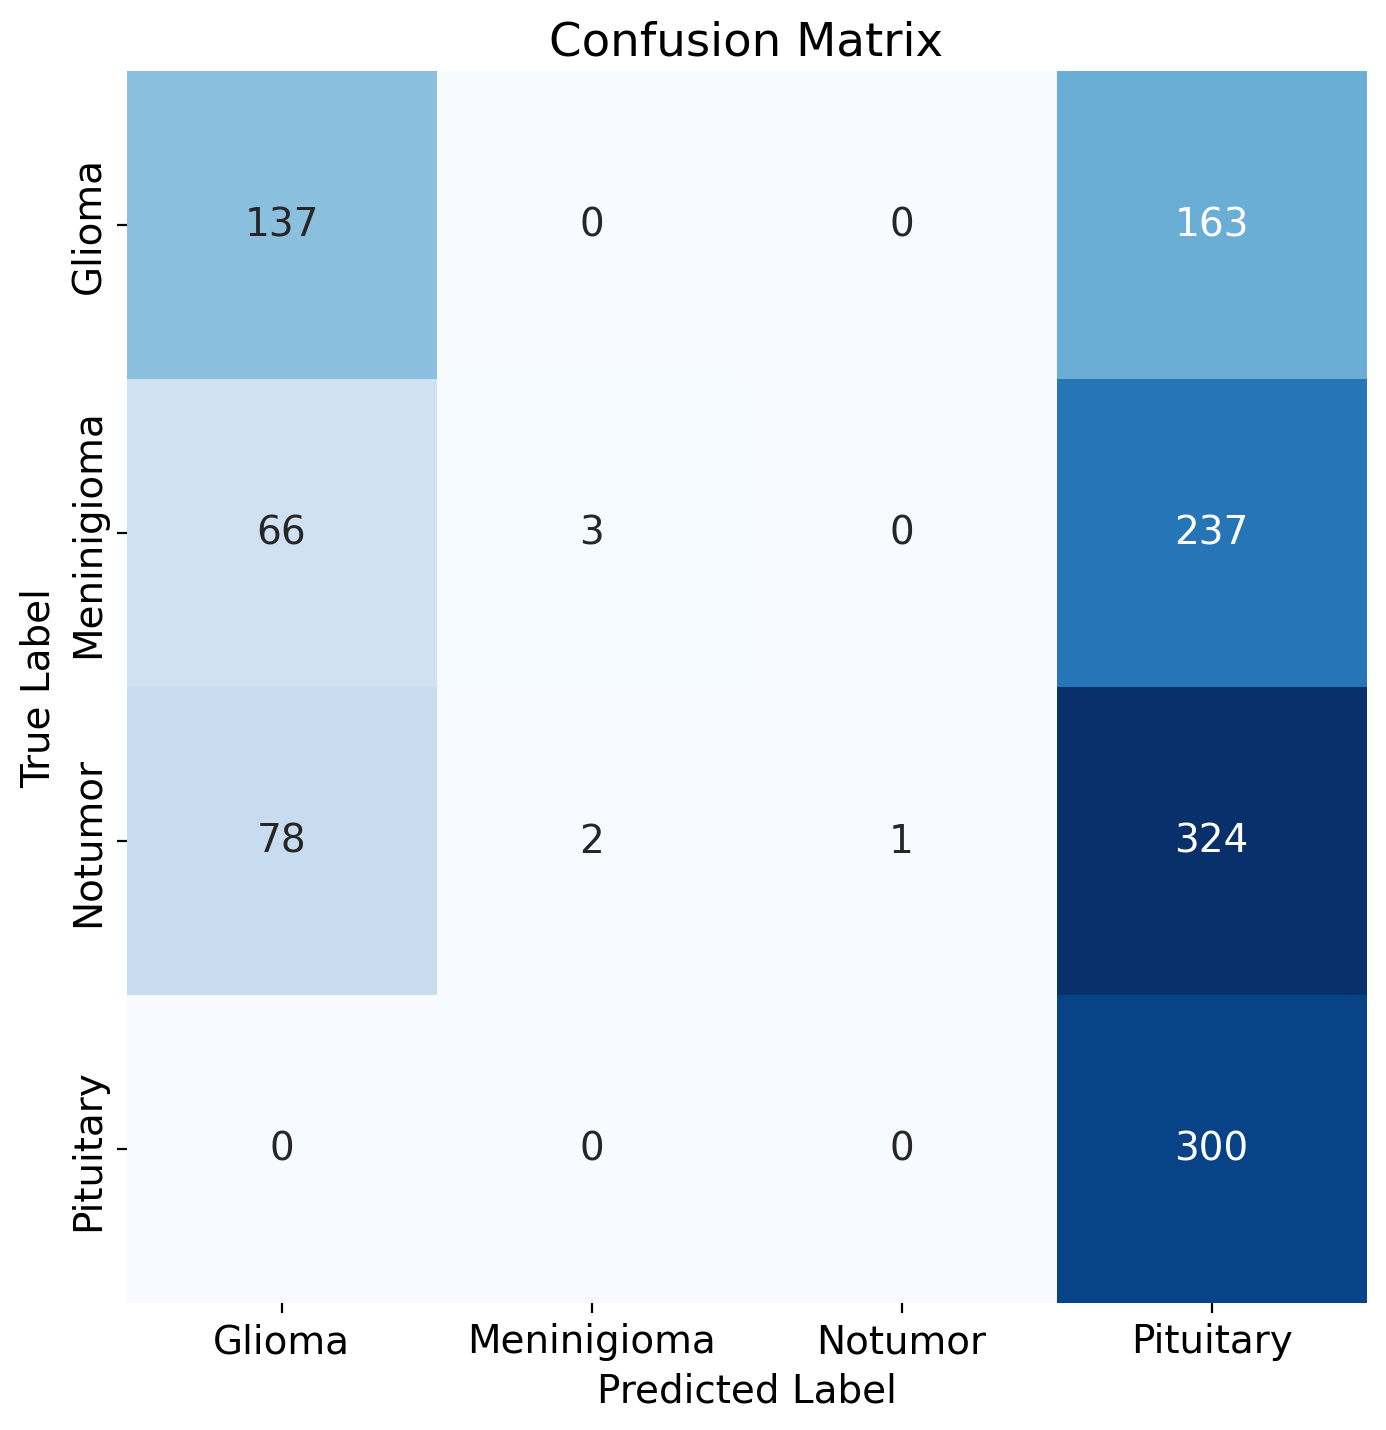

Class-wise metrics:
Class: Glioma
Precision: 0.4875
Recall: 0.4567
F1-Score: 0.4716

Class: Meninigioma
Precision: 0.6000
Recall: 0.0098
F1-Score: 0.0193

Class: Notumor
Precision: 1.0000
Recall: 0.0025
F1-Score: 0.0049

Class: Pituitary
Precision: 0.2930
Recall: 1.0000
F1-Score: 0.4532

Overall Accuracy: 0.3364


In [21]:
# Confusion matrix and netrics from predictions
plot_confusion_matrix(true_labels,
                      predicted_labels,
                      class_mappings,
                      metrics=True)